# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5816428.datarmor0/parcels-502027/libparcels_random_7a3ab9a7-9d80-4b1e-8b1e-e4e76b8aae31.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [5]:
client

Client Scheduler: tcp://10.148.0.220:42532 Dashboard: http://10.148.0.220:8787/status,Cluster Workers: 14 Cores: 28 Memory: 111.72 GiB


________
# 1. Read zonally-averaged LLC4320 spectra 
## (both Lag. and Eul.)
## (as a function of lat)

In [6]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [7]:
# load raw spectra
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds = xr.merge([ds_L, ds_E])
ds

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

In [8]:
# load spectra (with detrending)
ds_L_nomean = (p.load_diagnostic('spectra_uv_T60_mean1_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E_nomean = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean_lat.zarr'))
        .rename({'E_SSUV_T60_nomean': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds_nomean = xr.merge([ds_L_nomean, ds_E_nomean])
ds_nomean

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

# 2. Read real drifter spectra

In [9]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_raw = xr.open_zarr(data_dir+'E_drifter_raw.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window
#E_drifter = ds_raw.E_drifter_raw
E_drifter = E_drifter.assign_coords(lat=E_drifter.lat_bins) 
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
E_drifter_interp = E_drifter.interp(lat_bins = ds.lat,freq_time= ds.frequency/86400)
E_drifter_interp

<xarray.DataArray 'E_drifter_linear_window' (lat: 119, frequency: 1440)>
dask.array<dask_aware_interpnd, shape=(119, 1440), dtype=float64, chunksize=(119, 1440), chunktype=numpy.ndarray>
Coordinates:
    freq_cpd           (frequency) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    freq_time_spacing  float64 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    freq_time          (frequency) float64 -0.0001389 -0.0001387 ... 0.0001387
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98

In [10]:
E_drifter_raw = ds_raw.E_drifter_raw
E_drifter_raw = E_drifter_raw.assign_coords(lat=E_drifter_raw.lat_bins) 
E_drifter_raw_interp = E_drifter_raw.interp(lat_bins = ds.lat,freq_time= ds.frequency/86400)
E_drifter_raw_interp

<xarray.DataArray 'E_drifter_raw' (lat: 119, frequency: 1440)>
dask.array<dask_aware_interpnd, shape=(119, 1440), dtype=float64, chunksize=(119, 1440), chunktype=numpy.ndarray>
Coordinates:
    freq_cpd           (frequency) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    freq_time_spacing  float64 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    freq_time          (frequency) float64 -0.0001389 -0.0001387 ... 0.0001387
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98

____________
## 3. Plots of rotary spectra

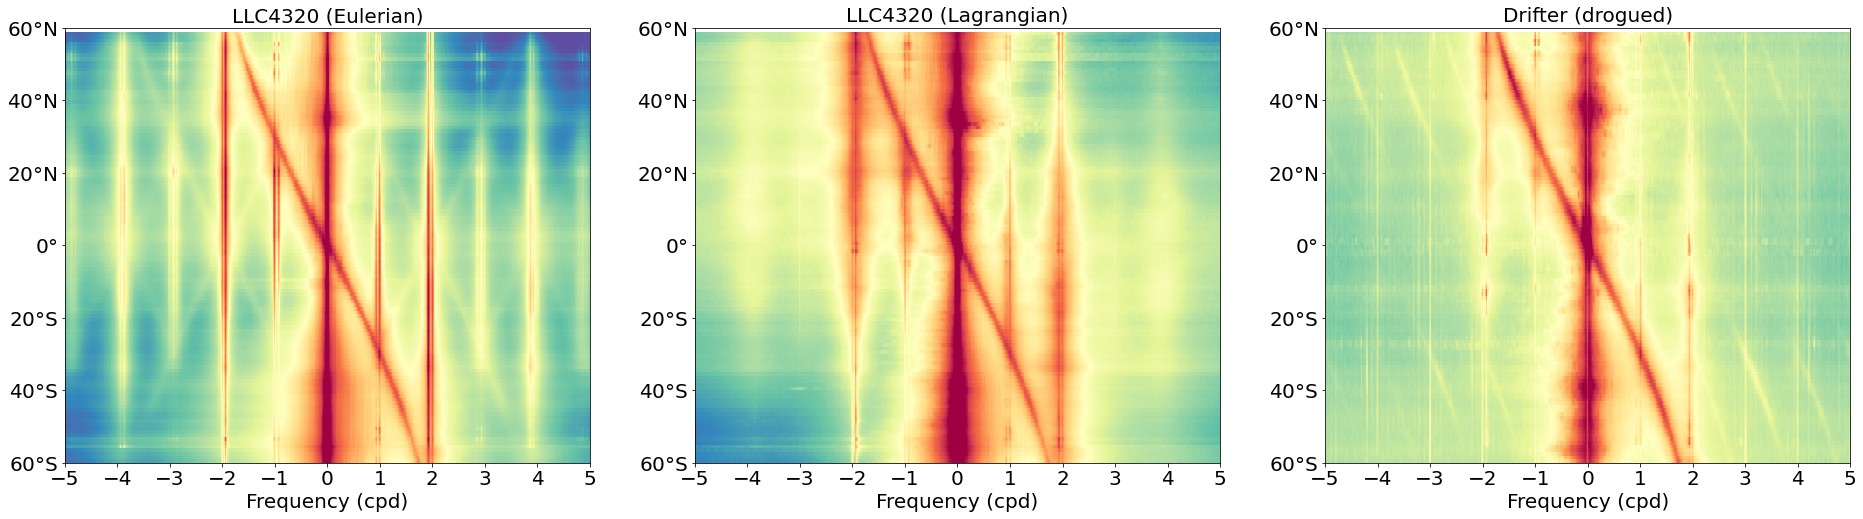

In [14]:
font_size = 20

fig, ax = plt.subplots(figsize=(32,8))

# LLC4320 Eulerian
ax = plt.subplot(1,3,1)
cax = np.log10(ds_nomean['E_Eulerian']).plot.pcolormesh(ax=ax, vmin=-5, vmax=-1, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)

# LLC420 Lagrangian
ax = plt.subplot(1,3,2)
cax = np.log10(ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, vmin=-5, vmax=-1, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian)',fontsize=font_size)

# Drifters
ax = plt.subplot(1,3,3)
cax = np.log10(E_drifter_interp/86400).plot.pcolormesh(ax=ax, vmin=-5, vmax=-1, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
#ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
#ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('Drifter (drogued)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_drifter.png')

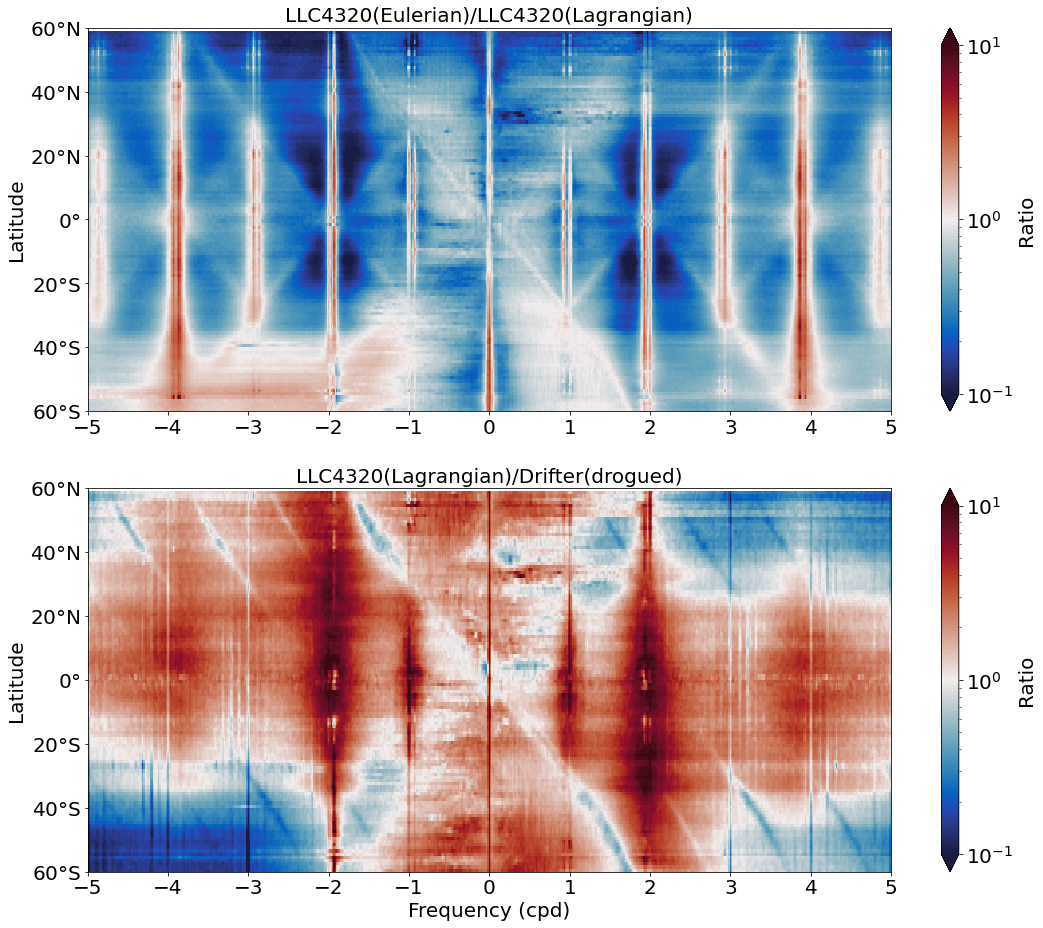

In [15]:
font_size = 20
fig, ax = plt.subplots(figsize=(18,24))

ax = plt.subplot(3,1,1)
cax = (ds_nomean['E_Eulerian']/ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Lagrangian)',fontsize=font_size)

ax = plt.subplot(3,1,2)
cax = (ds_nomean['E_Lagrangian']/(E_drifter_interp.sortby('freq_time')/86400)).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Lagrangian)/Drifter(drogued)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_drifter_ratio.png')

__________________
# 4. Band-integrated energy

### 1. with mean

In [13]:
E_Lagrangian = ds.E_Lagrangian
E_Eulerian = ds.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]

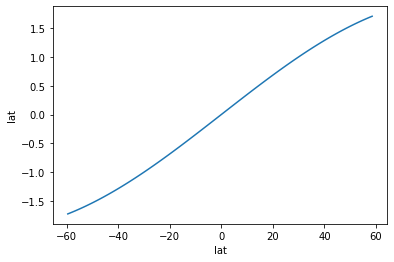

In [22]:
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat))
f_cpd_llc = f_llc*86400/2./np.pi
f_cpd_llc.plot()

In [15]:
E_KE_Lagrangian = (E_Lagrangian*df).sum(dim='frequency')
E_high_Lagrangian = (E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

E_KE_Eulerian = (E_Eulerian*df).sum(dim='frequency')
E_high_Eulerian = (E_Eulerian.where((abs(E_Eulerian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

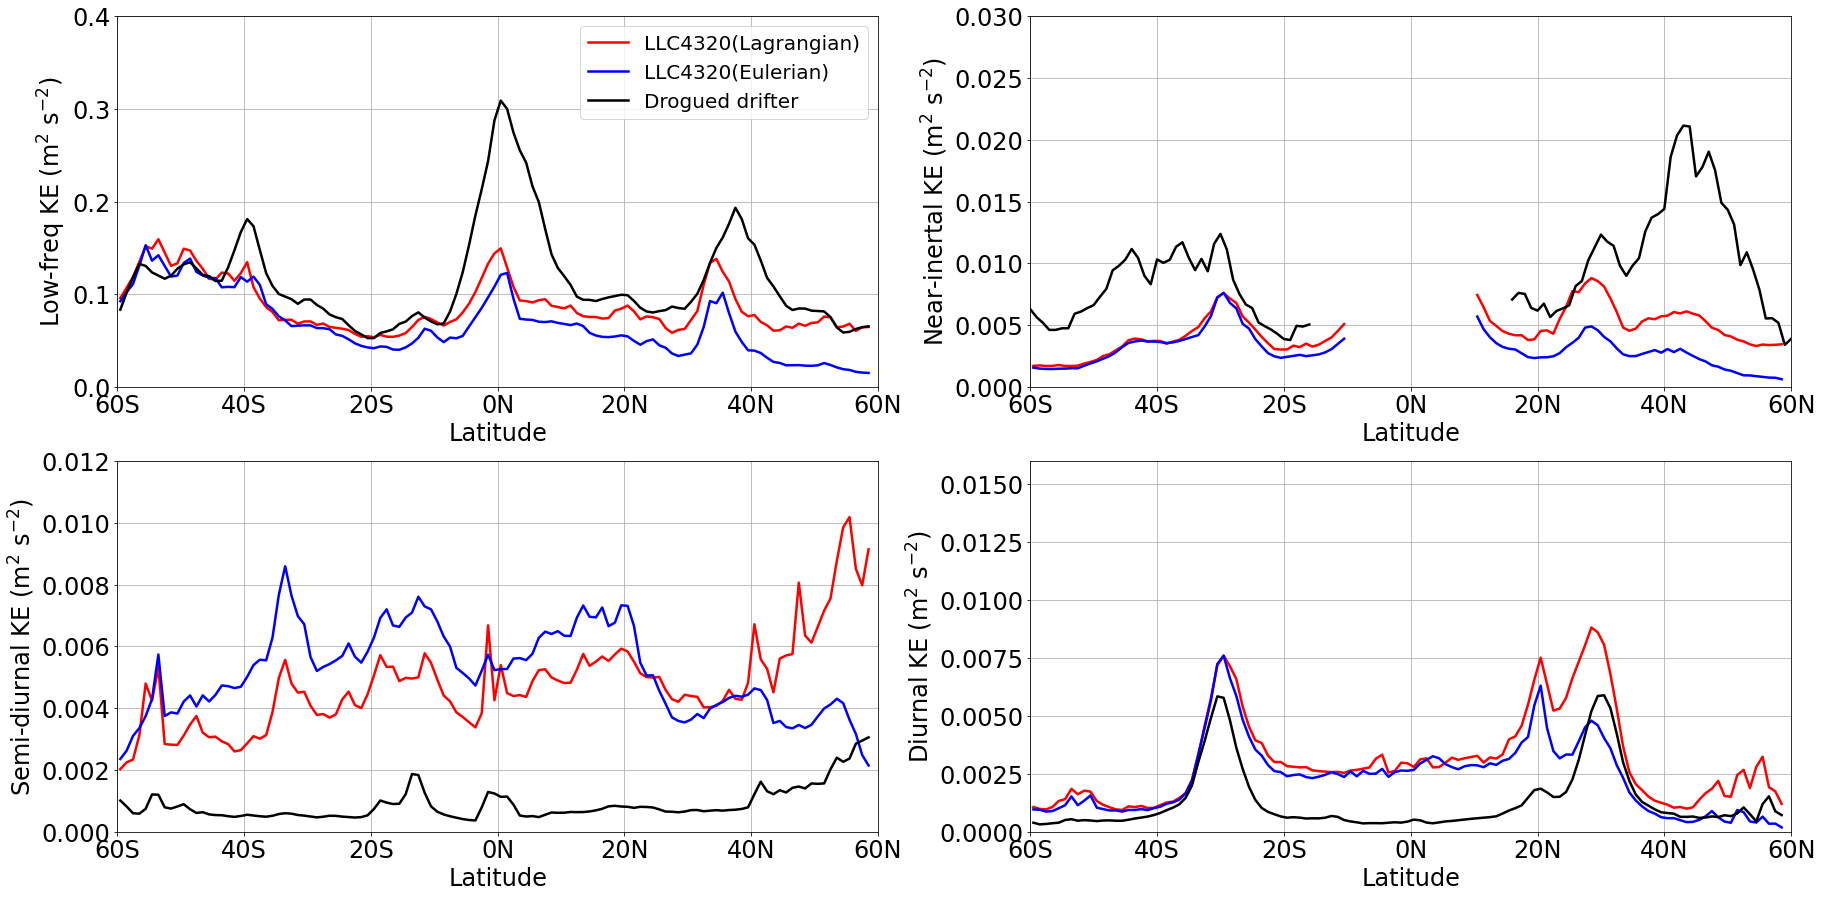

In [22]:
# compare each component by applying windowing
labels = ['LLC4320(Lagrangian)', 'LLC4320(Eulerian)', 'Drogued drifter']

#E_KE_drifter =  (E_drifter_interp*df/86400).sum(dim='frequency')
E_KE_drifter =  (E_drifter_raw_interp*df/86400).sum(dim='frequency')

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
(E_KE_Lagrangian).plot(color='red', label=labels[0], linewidth=2.5) # total energy
(E_KE_Eulerian).plot(color='blue', label=labels[1], linewidth=2.5) # total energy
E_KE_drifter.plot(color='black', label=labels[2], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Low-freq KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,2)
(4/3*E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(color='red', label=labels[0], linewidth=2.5) # energy around f
(4/3*E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(color='blue', label=labels[1], linewidth=2.5) # energy around f
(8/3/86400*E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='black', label=labels[2], linewidth=2.5) # energy around f
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.03])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Near-inertal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,3)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>1.9) & (abs(E_drifter_interp.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.012])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,4)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>0.9) & (abs(E_drifter_interp.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around diurnal frequencies
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_0dot1.png')

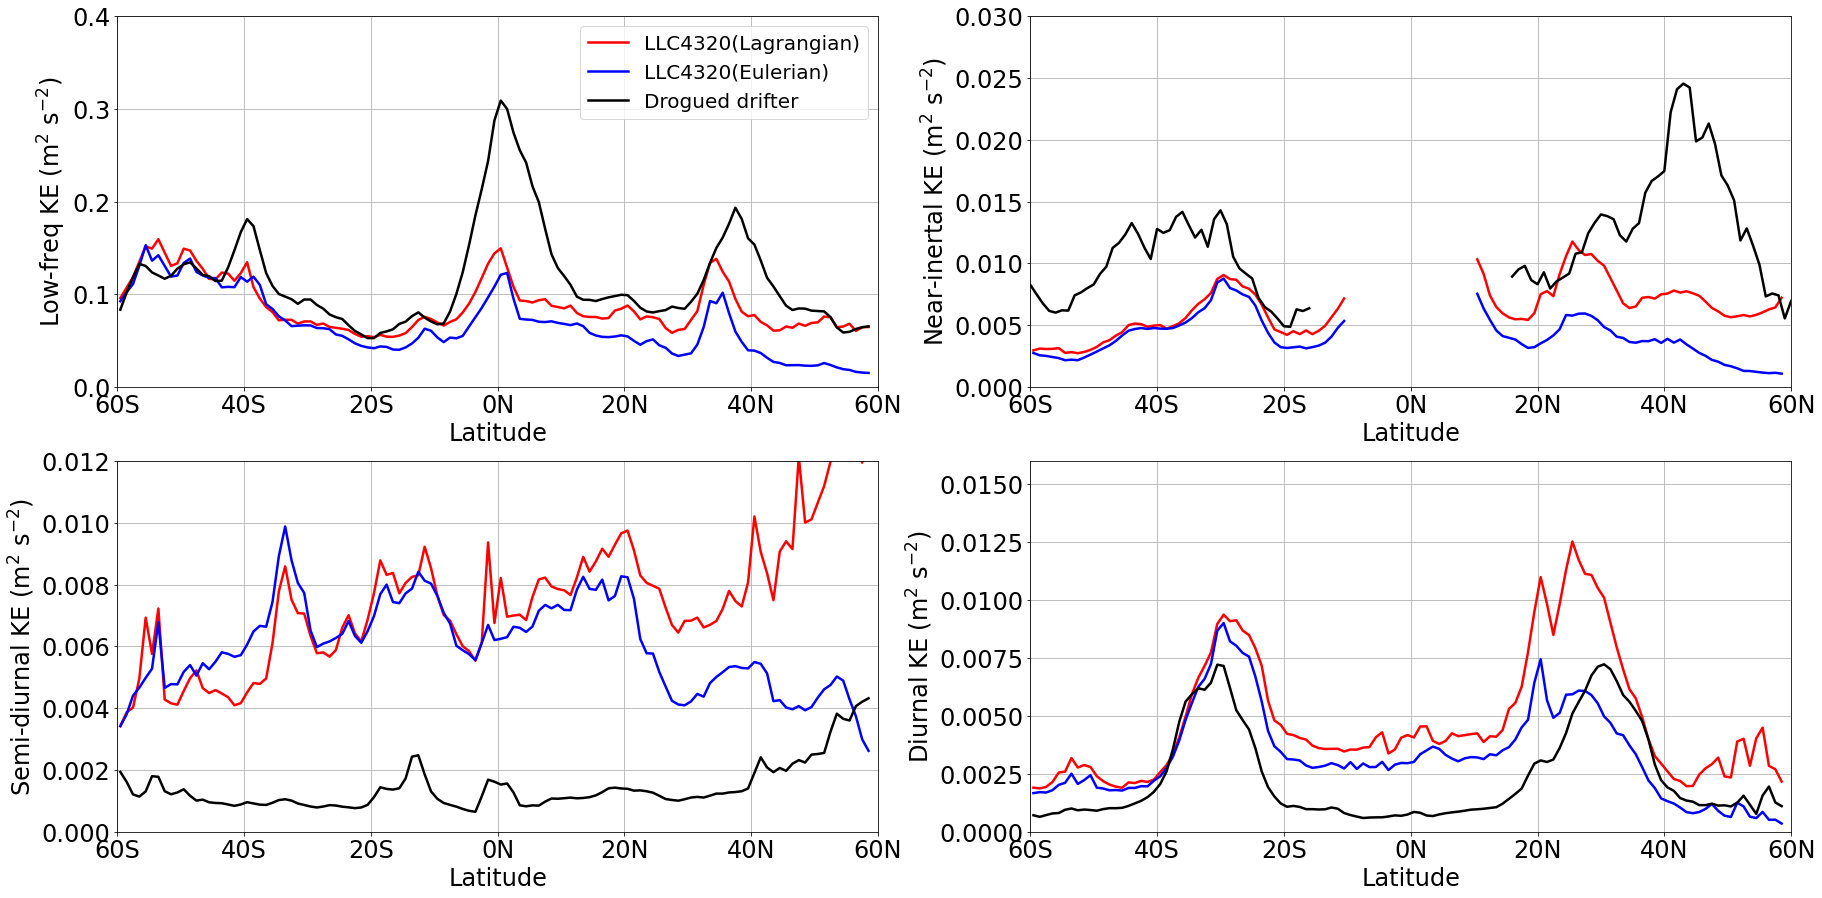

In [23]:
# compare each component by applying windowing
labels = ['LLC4320(Lagrangian)', 'LLC4320(Eulerian)', 'Drogued drifter']

#E_KE_drifter =  (E_drifter_interp*df/86400).sum(dim='frequency')
E_KE_drifter =  (E_drifter_raw_interp*df/86400).sum(dim='frequency')

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
(E_KE_Lagrangian).plot(color='red', label=labels[0], linewidth=2.5) # total energy
(E_KE_Eulerian).plot(color='blue', label=labels[1], linewidth=2.5) # total energy
E_KE_drifter.plot(color='black', label=labels[2], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Low-freq KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,2)
(4/3*E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.2, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(color='red', label=labels[0], linewidth=2.5) # energy around f
(4/3*E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.2, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(color='blue', label=labels[1], linewidth=2.5) # energy around f
(8/3/86400*E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.2, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='black', label=labels[2], linewidth=2.5) # energy around f
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.03])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Near-inertal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,3)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.8) & (abs(E_Lagrangian.frequency)<2.2) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>1.8) & (abs(E_Eulerian.frequency)<2.2) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>1.8) & (abs(E_drifter_interp.frequency)<2.2) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.012])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,4)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.8) & (abs(E_Lagrangian.frequency)<1.2) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>0.8) & (abs(E_Eulerian.frequency)<1.2) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>0.8) & (abs(E_drifter_interp.frequency)<1.2) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around diurnal frequencies
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_0dot2.png')

### 2. without mean

In [24]:
E_Lagrangian = ds_nomean.E_Lagrangian
E_Eulerian = ds_nomean.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]

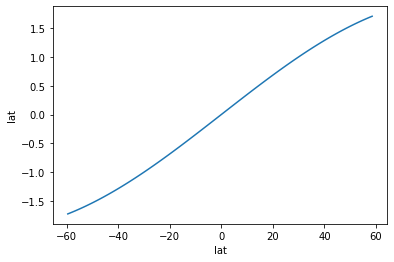

In [25]:
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat))
f_cpd_llc = f_llc*86400/2./np.pi
f_cpd_llc.plot()

In [26]:
E_KE_Lagrangian = (E_Lagrangian*df).sum(dim='frequency')
E_high_Lagrangian = (E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

E_KE_Eulerian = (E_Eulerian*df).sum(dim='frequency')
E_high_Eulerian = (E_Eulerian.where((abs(E_Eulerian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

Text(0.5, 1.0, '')

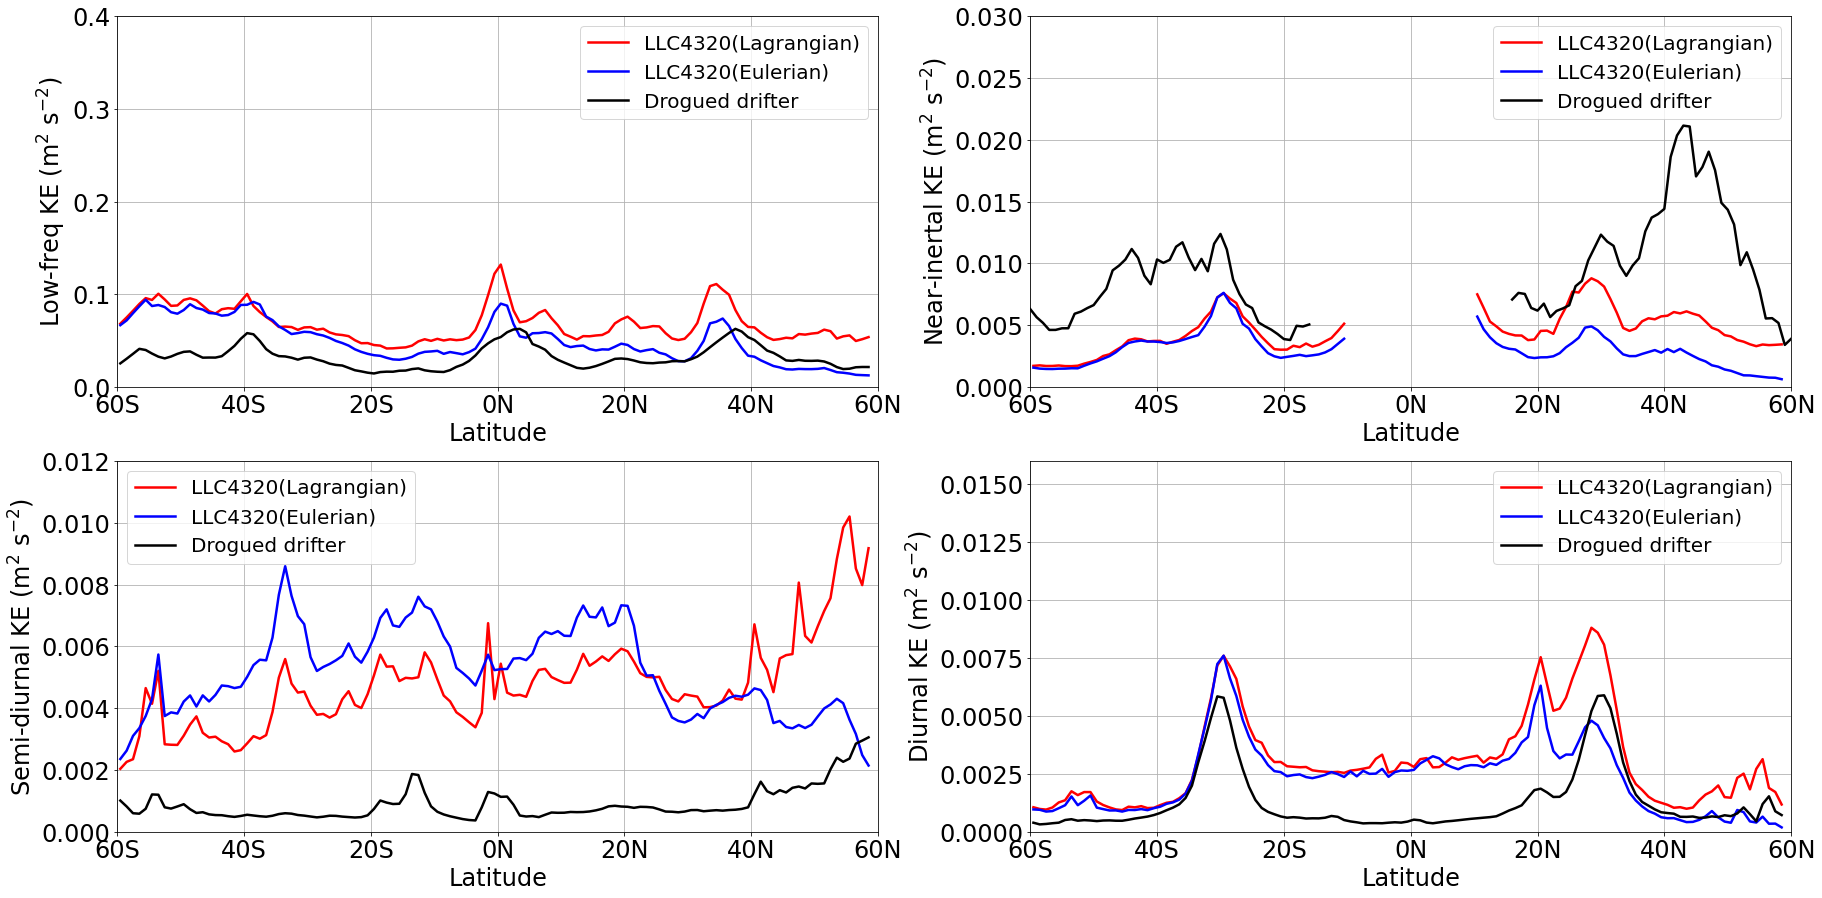

In [26]:
# compare each component by applying windowing
labels = ['LLC4320(Lagrangian)', 'LLC4320(Eulerian)', 'Drogued drifter']

E_KE_drifter =  (E_drifter_interp*df/86400).sum(dim='frequency')

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
(E_KE_Lagrangian).plot(color='red', label=labels[0], linewidth=2.5) # total energy
(E_KE_Eulerian).plot(color='blue', label=labels[1], linewidth=2.5) # total energy
E_KE_drifter.plot(color='black', label=labels[2], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Low-freq KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,2)
(4/3*E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(color='red', label=labels[0], linewidth=2.5) # energy around f
(4/3*E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(color='blue', label=labels[1], linewidth=2.5) # energy around f
(8/3/86400*E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='black', label=labels[2], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.03])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Near-inertal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,3)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>1.9) & (abs(E_drifter_interp.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.012])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,4)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>0.9) & (abs(E_drifter_interp.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)


## Close cluster

In [31]:
cluster.close()